# Day 10

## Part 1

- Toobs! Find the toob loop that intersects the `S` location.
- Then find the point farthest in the loop from the `S` location
- The distance along the toob from `S` to there is the answer.

In [48]:
from copy import deepcopy

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from advent_of_code_utils.advent_of_code_utils import (
    ParseConfig, parse_from_file, markdown
)

In [20]:
parser = ParseConfig('\n', ParseConfig('', str))

grid = parse_from_file('puzzle_input\\day_10.txt', parser)

In [21]:
# let's find all possible pipe paths and then try and visualise those

# row then column
NORTH = (-1, 0)
SOUTH = (1, 0)
EAST = (0, 1)
WEST = (0, -1)

faces ={
    '|': [NORTH, SOUTH],
    '-': [EAST, WEST],
    'L': [NORTH, EAST],
    'J': [NORTH, WEST],
    '7': [SOUTH, WEST],
    'F': [SOUTH, EAST],
    '.': [],
    'S': [NORTH, SOUTH, EAST, WEST]  # Could be any pair so initialy it's all
}

connected_direction = {
    NORTH: SOUTH,
    SOUTH: NORTH,
    EAST: WEST,
    WEST: EAST,
}

connection_grid = []
# go through all grid points checking what each point could connect to
for row_n, row in tqdm(enumerate(grid), desc='Finding connections'):
    connection_grid.append([])
    for col_n, value in enumerate(row):
        connected = []
        for row_off, col_off in faces[value]:
            row_adj, col_adj = row_n + row_off, col_n + col_off

            try:
                adj_value = grid[row_adj][col_adj]
            except IndexError:
                continue

            if connected_direction[(row_off, col_off)] in faces[adj_value]:
                connected.append((row_off, col_off))
        connection_grid[-1].append(connected)


Finding connections: 140it [00:00, 1852.88it/s]


Creating plot: 0it [00:00, ?it/s]

Creating plot: 555it [00:32, 16.92it/s]


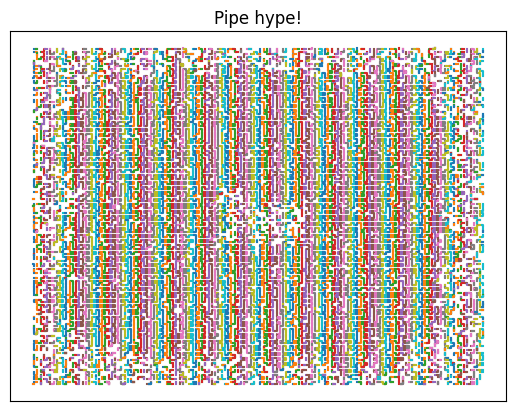

In [85]:
def plot_connection_grid(connection_grid: list[list[tuple[int, int]]]) -> None:
    """plots each spot's connections as it's own little line segment"""
    fig, ax = plt.subplots()

    y_dim = len(grid)

    for row_n, row in tqdm(enumerate(connection_grid), desc='Creating plot'):
        for col_n, connections in enumerate(row):
            match len(connections):
                case 0:
                    pass
                case 1:
                    row_off, col_off = connections[0]
                    x_vals = np.array((col_n + col_off * 0.5, col_n))
                    y_vals = np.array((row_n + row_off * 0.5, row_n))
                case 2:
                    (row_a, col_a), (row_b, col_b) = connections
                    x_vals = np.array((col_n + col_a * 0.5, col_n, col_n + col_b * 0.5))
                    y_vals = np.array((row_n + row_a * 0.5, row_n, row_n + row_b * 0.5))
            ax.plot(x_vals, y_dim - y_vals)
    ax.set_title('Pipe hype!')
    ax.set_xticks([])
    ax.set_yticks([])

plot_connection_grid(connection_grid)

In [33]:
# That looks neat! ok lets find lengths of continuous pipe next

grid_mask = [
    [len(connections) for connections in row] for row in connection_grid
]

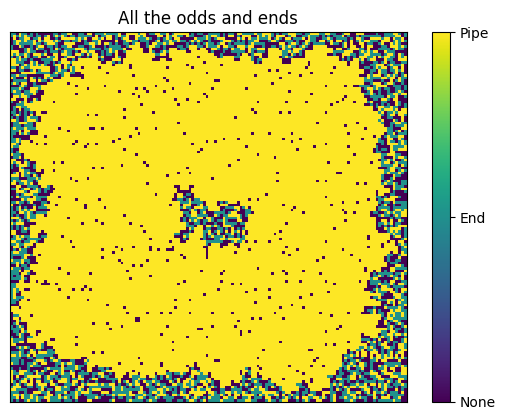

In [61]:
# let's see where those are before going on
def plot_mask(grid_mask: list[list[bool]], title: str):
    """plots the grid mask of where we still haven't considered yet"""
    fig, ax = plt.subplots()
    mask_array = np.flipud(np.array(grid_mask))
    im = ax.pcolormesh(mask_array)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    bar = fig.colorbar(im)
    bar.set_ticks([0, 1, 2])
    bar.set_ticklabels(['None', 'End', 'Pipe'])

plot_mask(grid_mask, 'All the odds and ends')

In [63]:
# start from all end points and pop them off the mask as we consider them
pipes = []
mask = deepcopy(grid_mask)
for row_n, row in tqdm(enumerate(connection_grid), desc='Joinery progress'):
    for col_n, connections in enumerate(row):
        if mask[row_n][col_n] in (0, 2):
            continue

        # travel along the pipe looking for the other end
        point = (row_n, col_n)
        pipe = []
        previous = connections[0]
        while (
            len(connection_grid[point[0]][point[1]]) > 1 or
            point == (row_n, col_n)
        ):
            # add this point
            pipe.append(point)
            # tick off the point on the mask
            mask[point[0]][point[1]] = 0
            # find next direction (that isn't the opposite of the previous)
            next_direction = [
                direction for direction in
                connection_grid[point[0]][point[1]]
                if direction != connected_direction[previous]
            ][0]
            # update the point and previous direction
            point = point[0] + next_direction[0], point[1] + next_direction[1]
            previous = next_direction
        # add the end point and tick that off too
        pipe.append(point)
        mask[point[0]][point[1]] = 0

        # add the completed pipe to the full list
        pipes.append(deepcopy(pipe))


Joinery progress: 0it [00:00, ?it/s]

Joinery progress: 140it [00:00, 2891.04it/s]


Rendering pipes:   3%|▎         | 38/1117 [00:00<00:02, 360.73it/s]

Rendering pipes: 100%|██████████| 1117/1117 [00:01<00:00, 777.75it/s] 


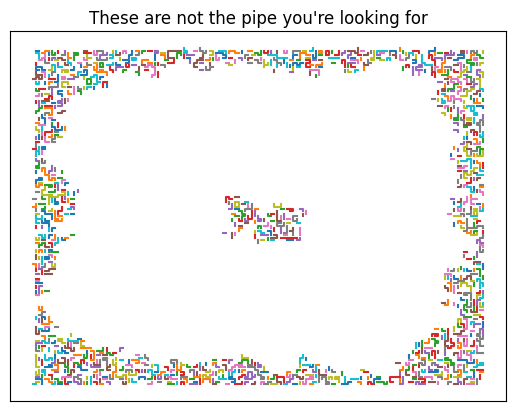

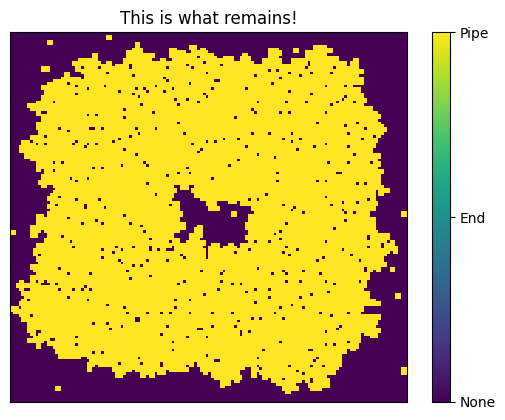

In [87]:
# let's plot again!
def plot_pipes(
    pipes: list[list[tuple[int, int]]], colour: str = None,
    ax: plt.Axes = None, title: str = None
) -> None:
    """plots each each pipe"""
    if ax is None:
        fig, ax = plt.subplots()

    y_dim = len(grid)

    for pipe in tqdm(pipes, desc='Rendering pipes'):
        y_vals, x_vals = map(list, zip(*pipe))
        if colour is None:
            ax.plot(np.array(x_vals), y_dim - np.array(y_vals))
        else:
            ax.plot(
                np.array(x_vals), y_dim - np.array(y_vals),
                color=colour
            )
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plot_pipes(pipes, title='These are not the pipe you\'re looking for')
plot_mask(mask, 'This is what remains!')


In [69]:
# looks like there may be a few little loops other than our main one
# first find the starting point
def find_start(grid: list[list[str]]) -> tuple[int, int]:
    """returns the starting point"""
    for row_n, row in enumerate(grid):
        connection_grid.append([])
        for col_n, value in enumerate(row):
            if value == 'S':
                return (row_n, col_n)

starting_point = find_start(grid)

# now we can just find our pipe loop from that
pipe_loop = []
point = starting_point
previous = connection_grid[point[0]][point[1]][0]
first = True  # a latch so we can do the starting point once
while point != starting_point or first:
    first = False
    # add this point
    pipe_loop.append(point)
    # find next direction (that isn't the opposite of the previous)
    next_direction = [
        direction for direction in
        connection_grid[point[0]][point[1]]
        if direction != connected_direction[previous]
    ][0]
    # update the point and previous direction
    point = point[0] + next_direction[0], point[1] + next_direction[1]
    previous = next_direction

Rendering pipes:   2%|▏         | 25/1117 [00:00<00:04, 230.32it/s]

Rendering pipes: 100%|██████████| 1/1 [00:00<00:00, 58.69it/s]


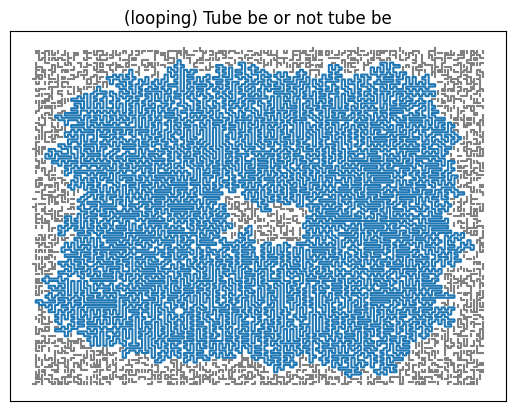

In [88]:
fig, ax = plt.subplots()
plot_pipes(pipes, colour='gray', ax=ax)
plot_pipes([pipe_loop], ax=ax, title='(looping) Tube be or not tube be')

In [81]:
# final stretch! Just find find half the length of the loop and we're done!
markdown(
    '### Solution',
    'The furthest point along the looping pipe from the start is '
    f'{len(pipe_loop) // 2} steps away.'
)

### Solution
The furthest point along the looping pipe from the start is 6773 steps away.

## Part 2

- Find the number of tiles enclosed by the loop where enclosed means that if the pipe was somehow pulled taught like a rope it would snag on the tile

In trying to actually define what enclosed means I realised that the number of times you have to cross the pipe to get to get to a point can reveal if a point is enclosed.

If we come in from the left, for instance, and cross pipe an odd number of times, that tile must be within the loop.

In [118]:
def count_enclosed(
    grid: list[list[str]], loop: list[tuple[int, int]], debug: bool = False
) -> int:
    """returns the number of enclosed tiles"""
    enclosed_tiles = 0
    for n_row, row in tqdm(enumerate(grid), desc='Finding enclosed tiles'):
        crossed = False
        last_bend = None
        debug_str = ''
        for n_col, value in enumerate(row):
            # if tile is part of the loop - update crossed status
            if (n_row, n_col) in loop:
                debug_str += value
                # always cross on the exit of a colinear section
                match value:
                    case '|':
                        crossed = not crossed
                    case '-':  # crossing will already be counted
                        pass
                    case 'L':
                        last_bend = 'L'
                    case 'J':
                        if last_bend == 'F':
                            crossed = not crossed
                        last_bend = 'J'
                    case '7':
                        if last_bend == 'L':
                            crossed = not crossed
                        last_bend = '7'
                    case 'F':
                        last_bend = 'F'
            # if not part of the loop record the status
            else:
                if crossed:
                    debug_str += 'I'
                else:
                    debug_str += 'O'
                enclosed_tiles += crossed

        if debug:
            print(debug_str)
    return enclosed_tiles

example_grid = parse_from_file('puzzle_input\\day_10_example.txt', parser)
example_loop = []  # doesn't need to be in order just a list of points in loop
for n_row, row in enumerate(example_grid):
    for n_col, tile in enumerate(row):
        if tile != '.':
            example_loop.append((n_row, n_col))

print(count_enclosed(example_grid, example_loop, debug=True))


Finding enclosed tiles: 10it [00:00, 3342.61it/s]

OF----7F7F7F7F-7OOOO
O|F--7||||||||FJOOOO
O||OFJ||||||||L7OOOO
FJL7L7LJLJ||LJIL-7OO
L--JOL7IIILJS7F-7L7O
OOOOF-JIIF7FJ|L7L7L7
OOOOL7IF7||L7|IL7L7|
OOOOO|FJLJ|FJ|F7|OLJ
OOOOFJL-7O||O||||OOO
OOOOL---JOLJOLJLJOOO
8


In [119]:
# cool that looks to work, let's wrap things up!
enclosed = count_enclosed(grid, pipe_loop)

Finding enclosed tiles: 140it [00:04, 31.87it/s]


In [120]:
markdown(
    '### Solution',
    f'The number of tiles enclosed by the pipe loop is: {enclosed}'
)

### Solution
The number of tiles enclosed by the pipe loop is: 493